In [2]:
from retrieve_geo import GeoInfo
import numpy as np
import datetime as dt

%matplotlib inline

### __Specify Test Coordinates and Retrieve Geographic Information__

In [3]:
# x = -2193465
# y = 1885485

x = 1616750
y = 2100076
geo = GeoInfo(x=str(x), y=str(y))

# lat = 40.273651
# lon = -76.871876
# geo = GeoInfo(x=str(lon), y=str(lat), units="geo")
# x = geo.coord.x
# y = geo.coord.y

__Display the pixel upper left x and y coordinates__

In [4]:
px = geo.pixel_coord_ul.x
py = geo.pixel_coord_ul.y
px, py

(1616745, 2100105)

In [6]:
x, y  # original entered coordinates

(1616750, 2100076)

## __Use the lcmap-nemo Service to Retrieve PyCCD Segments and Processing Masks__

In [7]:
from nemo_basics import pixels, segments, getsnap, chips
from operator import itemgetter

__getsnap(x, y) will return the chip ulx and uly__

In [8]:
snap = getsnap(x, y)

In [9]:
snap

{'tile': {'proj-pt': [1484415.0, 2114805.0], 'grid-pt': [27.0, 8.0]},
 'chip': {'proj-pt': [1616415.0, 2102805.0], 'grid-pt': [1394.0, 404.0]}}

In [10]:
cx, cy = snap['chip']['proj-pt']
cx, cy

(1616415.0, 2102805.0)

__Use the nemo chips resource to get dates.  chips() returns a list with a single item which is a dict, the 'dates' key contains all of the chip dates__

In [12]:
chips(cx, cy)[0].keys()

dict_keys(['cx', 'cy', 'dates'])

In [13]:
chip_dates = chips(cx, cy)[0]['dates']

__Show the end points of the date range - Note they are returned in descending order__

In [17]:
chip_dates[-1], chip_dates[0]

('1982-11-18', '2017-12-28')

__Get the processing mask for the entire chip__

In [18]:
chip_proc_mask = pixels(cx, cy)

In [19]:
type(chip_proc_mask)

list

__Define a function that retrieves the processing mask for a single pixle__

In [21]:
def pixel_proc_mask(chip_pixels: list, pixel_x: int, pixel_y: int):
    """
    Get the processing mask for a single pixel in the chip
    """
    gen = filter(lambda i: i['px'] == pixel_x and i['py'] == pixel_y, chip_pixels)

    return next(gen, None)

__Show what kind of information is stored for each pixel__

In [22]:
target_pixel = pixel_proc_mask(chip_proc_mask, px, py)

In [23]:
target_pixel.keys()

dict_keys(['cx', 'cy', 'px', 'py', 'mask'])

__Reference the Processing Mask Directly, but in Reverse so that it matches Chip dates and ARD dates - [::-1] is a scary looking way of reversing a list without altering the list itself__

In [26]:
proc_mask = target_pixel['mask'][::-1]

__Retrieve the Change Model Segments for the Target Pixel within the Returned Chip Results i.e. segments(cx, cy) and Sort the Pixel Segments Based on the 'sday' Values__

In [27]:
chip_segs = segments(cx, cy)

In [28]:
segs = sorted([i for i in chip_segs if i['px'] == px and i['py'] == py], key=itemgetter('sday'))

In [29]:
len(segs)

3

__Display what kind of information is stored for each Pixel__

In [30]:
segs[0].keys()

dict_keys(['thint', 'bday', 'grmag', 'blint', 'grrmse', 's2mag', 'sday', 'grint', 'grcoef', 'px', 'rermse', 's1mag', 'eday', 'nimag', 'thcoef', 'blcoef', 's1rmse', 'nicoef', 's2int', 's2rmse', 'thmag', 'reint', 'cx', 'cy', 's1int', 'blrmse', 'remag', 'thrmse', 's2coef', 'chprob', 'curqa', 'blmag', 'niint', 's1coef', 'py', 'nirmse', 'recoef'])

__Reference useful date parameters for each segment.  Also, we will need a list of ordinal dates for plotting model curves later, so here we convert the strings to ordinal time integer values and create the list of dates.__

In [69]:
seg_dates = {n: {'sday': segs[n]['sday'],
                 'eday': segs[n]['eday'],
                 'bday': segs[n]['bday'],
                 'orddays': np.arange(dt.datetime.strptime(segs[n]['sday'], '%Y-%m-%d').toordinal(),
                                      dt.datetime.strptime(segs[n]['eday'], '%Y-%m-%d').toordinal() + 1)}
             for n in range(len(segs))}

# Get the length in days for each segment
for s in seg_dates.keys():
    seg_dates[s]['ndays'] = len(seg_dates[s]['orddays'])
    
seg_dates[0]

{'sday': '1984-08-27',
 'eday': '2006-12-06',
 'bday': '2007-04-21',
 'orddays': array([724515, 724516, 724517, ..., 732649, 732650, 732651]),
 'ndays': 8137}

## __Use lcmap-merlin to Retrieve the ARD Observations for the Target Pixel__

In [32]:
import merlin
import merlin_cfg
from nemo_basics import ard_url

__Generate a configuration that merlin will use to call the lcmap-chipmunk service, currently just requesting ARD for the NIR Surface Reflectance__

In [33]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

In [34]:
cfg = merlin_cfg.make_cfg([b+'s' for b in bands], ard_url)
cfg

{'grid_fn': functools.partial(<function grid at 0x0000019F7793E840>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/grid'),
 'dates_fn': <function merlin.dates.symmetric(datemap)>,
 'chips_fn': functools.partial(<function chips at 0x0000019F7793E730>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/chips'),
 'specs_fn': functools.partial(<function mapped at 0x0000019F77951F28>, ubids={'blues': ['LC08_SRB2', 'LE07_SRB1', 'LT05_SRB1', 'LT04_SRB1'], 'greens': ['LC08_SRB3', 'LE07_SRB2', 'LT05_SRB2', 'LT04_SRB2'], 'reds': ['LC08_SRB4', 'LE07_SRB3', 'LT05_SRB3', 'LT04_SRB3'], 'nirs': ['LC08_SRB5', 'LE07_SRB4', 'LT05_SRB4', 'LT04_SRB4'], 'swir1s': ['LC08_SRB6', 'LE07_SRB5', 'LT05_SRB5', 'LT04_SRB5'], 'swir2s': ['LC08_SRB7', 'LE07_SRB7', 'LT05_SRB7', 'LT04_SRB7'], 'thermals': ['LC08_BTB10', 'LE07_BTB6', 'LT05_BTB6', 'LT04_BTB6']}),
 'format_fn': <function merlin.formats.pyccd(x, y, locations, dates_fn, specmap, chipmap)>,
 'registry_fn': functools.partial(<functi

__We can use the segs to determine the acquisition date range of ARD to Request__

In [35]:
acquired = chip_dates[-1], chip_dates[0]
acquired

('1982-11-18', '2017-12-28')

__Request the Timeseries ARD for the given acquisition period.  merlin.create() returns the ARD for the entire Chip so we use filter() and next() to retrieve just the target pixel ARD.__

In [39]:
chip_ard = merlin.create(x, y, acquired=f'{acquired[0]}/{acquired[1]}', cfg=cfg)

__Define a function that returns the pixel rod of ARD__

In [41]:
def pixel_ard(ard: list, pixel_x: int, pixel_y: int):
    """
    Return the pixel rod of ARD acquisitions

    """
    gen = filter(lambda x: x[0][2] == pixel_x and x[0][3] == pixel_y, ard)

    return next(gen, None)

In [42]:
def rescale_thermal(thermals):
    """
    Fix the scaling of the Brightness Temperature

    """
    temp_thermal = np.copy(thermals)
    
    fill_mask = temp_thermal != -9999

    temp_thermal[fill_mask] = temp_thermal[fill_mask] * 10 - 27315

    return temp_thermal

In [43]:
seg_ard = pixel_ard(chip_ard, px, py)

In [44]:
seg_ard[1]['thermals'] = rescale_thermal(seg_ard[1]['thermals'])

__Define a dict for referencing the segment model coefficients and intercept for each band__

In [45]:
key_lookup = {'blue': {'coefs': 'blcoef',
                       'inter': 'blint'},
              'green': {'coefs': 'grcoef',
                        'inter': 'grint'},
              'red': {'coefs': 'recoef',
                      'inter': 'reint'},
              'nir': {'coefs': 'nicoef',
                      'inter': 'niint'},
              'swir1': {'coefs': 's1coef',
                        'inter': 's1int'},
              'swir2': {'coefs': 's2coef',
                        'inter': 's2int'},
              'thermal': {'coefs': 'thcoef',
                          'inter': 'thint'}
             }

__Define a Function to Calculate Curve Values for a Change Model Over a Specified Sequence of Days__

In [46]:
def predicts(days, coef, intercept):
    return (intercept + coef[0] * days +
            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))

In [70]:
curves = {n: {band: predicts(seg_dates[n]['orddays'],
                             segs[n][key_lookup[band]['coefs']],
                             segs[n][key_lookup[band]['inter']]) for band in bands}
         for n in range(len(segs))}

In [71]:
curves[0]  # Display this for example

{'blue': array([387.58743786, 385.75124216, 383.9025909 , ..., 348.00815596,
        348.76229699, 349.41218435]),
 'green': array([500.63759308, 499.82046602, 499.0572783 , ..., 417.30411496,
        416.19976301, 415.03953865]),
 'red': array([362.14246908, 359.82696328, 357.5340578 , ..., 514.55071679,
        514.02607429, 513.23451682]),
 'nir': array([3289.72114612, 3274.4950553 , 3259.44921429, ..., 1095.02949492,
        1075.00987563, 1055.76281717]),
 'swir1': array([1364.37189849, 1356.01160193, 1347.50180843, ..., 1253.70508128,
        1252.05837506, 1250.09480778]),
 'swir2': array([528.40496129, 523.41981256, 518.28227395, ..., 761.26503478,
        764.22114435, 766.81848061]),
 'thermal': array([2042.31148779, 2031.52024579, 2020.28949393, ...,  512.58008349,
         490.98976105,  469.19988247])}

In [ ]:
# curves = {band: predicts(days, 
#                          segs[0][key_lookup[band]['coefs']],
#                          segs[0][key_lookup[band]['inter']]) for band in bands}

__Confirm that the number of curve values generated is equal to the number of dates__

In [72]:
for c in curves.keys():
    for b in bands:
        assert len(curves[c][b]) == seg_dates[c]['ndays']

## __Plot the Change Model Curve__

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import OrderedDict

In [60]:
def date_to_ord(indate: str, f: str='%Y-%m-%d'):
    """
    Return an integer value representing an ordinal date
    
    """
    return dt.datetime.strptime(indate, f).toordinal()

In [ ]:
def plot_curves(ax, ax_n, x_vals, y_vals, linestyle='-'):
    ax[ax_n, 0].plot(x_vals, y_vals, linestyle=linestyle, label=f'segment {ax_n+1}')
    
def plot_vlines(ax, ax_n, val, color, label, linestyle='-'):
    ax[ax_n, 0].axvline(val, color=color, linestyle=linestyle, label=label)

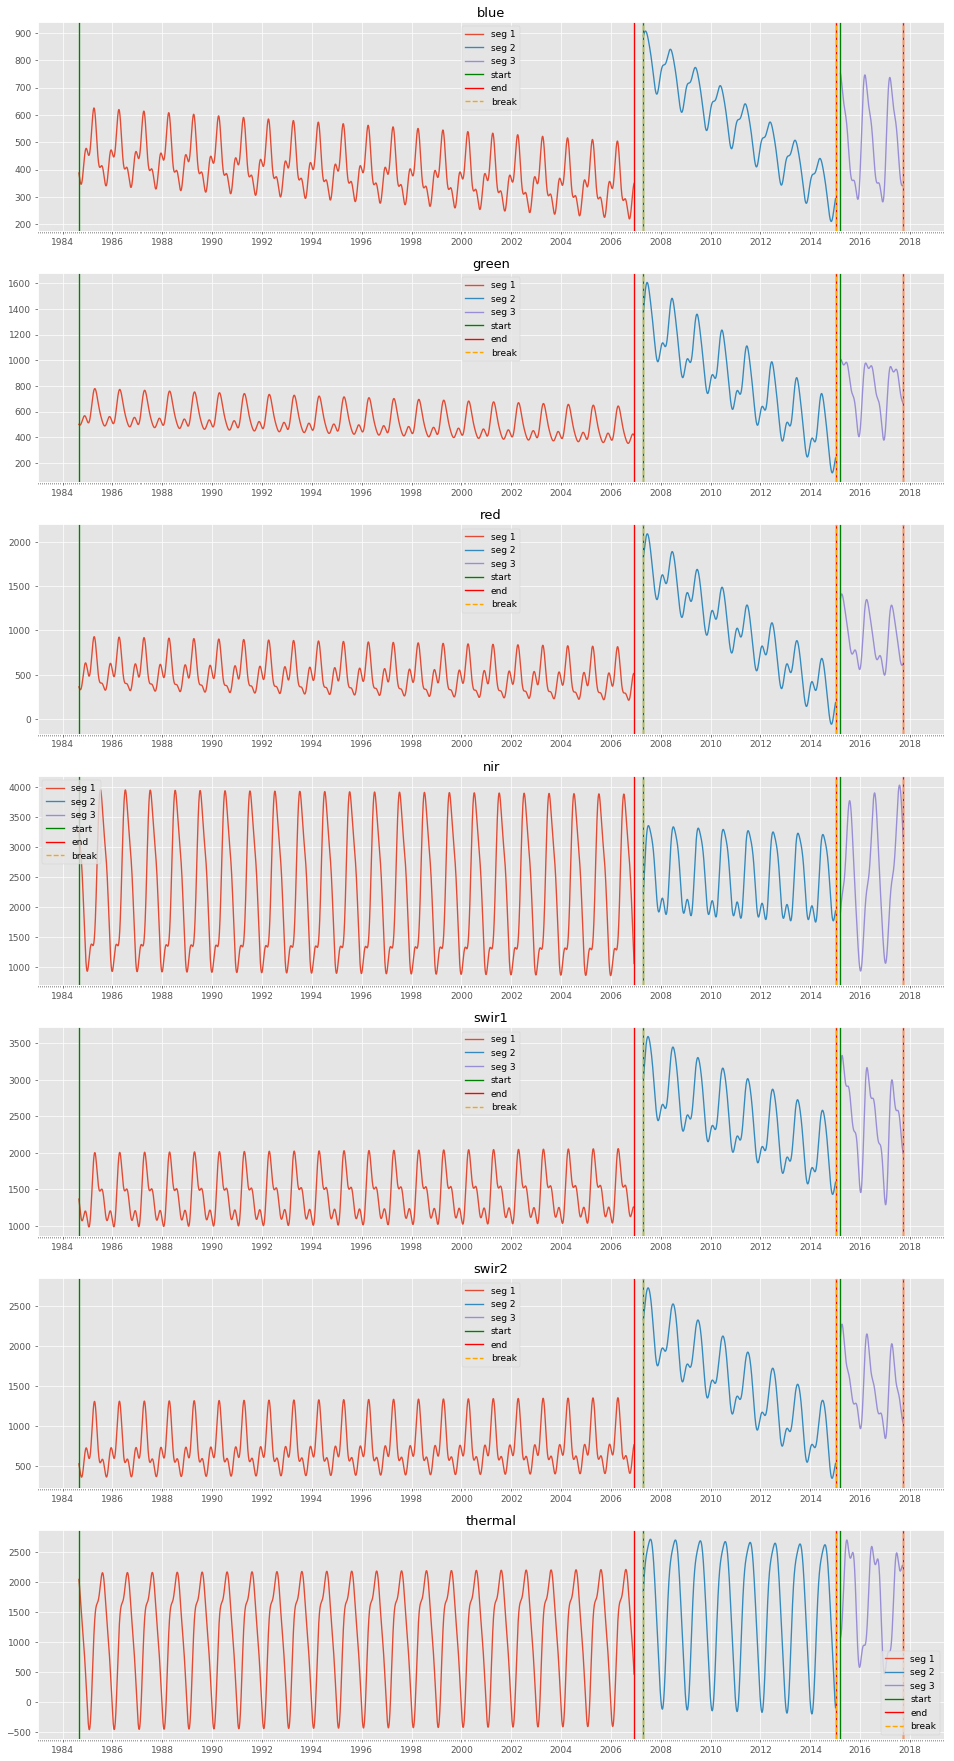

In [73]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

years = mdates.YearLocator(base=2)   # every other year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add curves to the plot
        axes[ind, 0].plot(seg_dates[n]['orddays'], curves[n][b], label=f'seg {n+1}')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['sday']), color='g', label='start')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['eday']), color='r', label='end')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['bday']), color='orange', linestyle='--', label='break')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        axes[ind, 0].set_title(b)

        axes[ind, 0].xaxis.set_major_locator(years)
        axes[ind, 0].xaxis.set_major_formatter(yearsFmt)
        axes[ind, 0].xaxis.set_minor_locator(months)
        
#         axes[ind, 0].legend()
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        axes[ind, 0].legend(by_label.values(), by_label.keys())

In [64]:
by_label

OrderedDict([('segment 1', <matplotlib.lines.Line2D at 0x19f15c2fa90>),
             ('start', <matplotlib.lines.Line2D at 0x19f160a59b0>),
             ('end', <matplotlib.lines.Line2D at 0x19f160adb38>),
             ('break', <matplotlib.lines.Line2D at 0x19f160adef0>),
             ('segment 2', <matplotlib.lines.Line2D at 0x19f15fcd080>),
             ('segment 3', <matplotlib.lines.Line2D at 0x19f160a5080>)])

__Lets mask the ARD observations using the processing mask.  To do this, the length of both of these sequences must be equal__

In [74]:
assert len(proc_mask) == len(seg_ard[1]['nirs'])

In [75]:
len(seg_ard[1]['nirs'])

1756

In [76]:
# ard_proc = seg_ard[1]['nirs'][np.array(proc_mask, dtype=np.bool)]

ard_proc = {b: seg_ard[1][b+'s'][np.array(proc_mask, dtype=np.bool)] for b in bands}

In [77]:
dates_proc = np.array(
                      [dt.datetime.strptime(c, '%Y-%m-%d').toordinal() for c in chip_dates]
                      )[np.array(proc_mask, dtype=np.bool)]

__Make sure that the length of the masked ARD and dates arrays are equal__

In [78]:
assert len(ard_proc['nir']) == len(dates_proc)

In [80]:
len(ard_proc['nir'])

360

## __Plot the Clear ARD Observations Along with the Model Curve__

In [ ]:
plt.style.use('ggplot')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

for num, b in enumerate(bands):
    axes[num, 0].set_title(b)
    
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')
    
    axes[num, 0].plot(days, curves[b], linewidth=2.5, label='model')
    
    axes[num, 0].axvline(sday, c='g', label='start')
    axes[num, 0].axvline(eday, c='r', label='end')
    axes[num, 0].axvline(bday, c='orange', linestyle='--', label='break')
    
    axes[num, 0].xaxis.set_major_locator(years)
    axes[num, 0].xaxis.set_major_formatter(yearsFmt)
    axes[num, 0].xaxis.set_minor_locator(months)
    
    axes[num, 0].set_xlim(736000, 737000)
    
    axes[num, 0].legend()

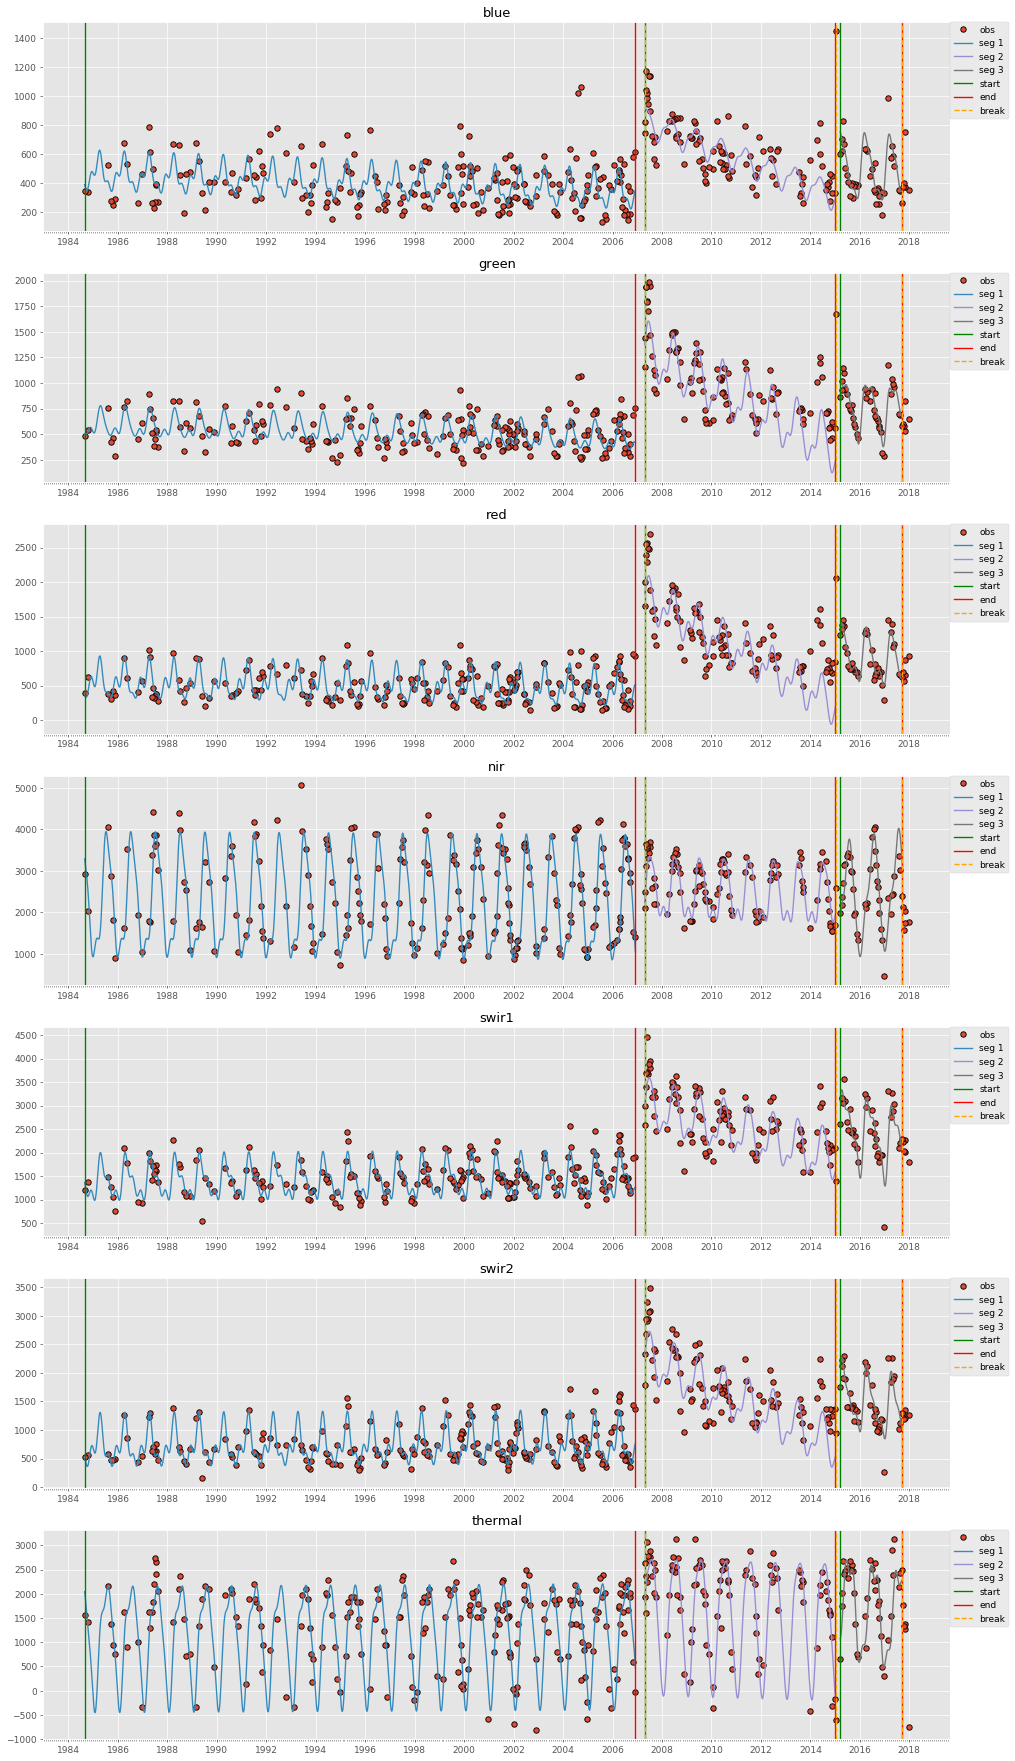

In [82]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

years = mdates.YearLocator(base=2)   # every other year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

for num, b in enumerate(bands):
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add curves to the plot
        axes[ind, 0].plot(seg_dates[n]['orddays'], curves[n][b], label=f'seg {n+1}')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['sday']), color='g', label='start')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['eday']), color='r', label='end')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['bday']), color='orange', linestyle='--', label='break')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        axes[ind, 0].set_title(b)

        axes[ind, 0].xaxis.set_major_locator(years)
        axes[ind, 0].xaxis.set_major_formatter(yearsFmt)
        axes[ind, 0].xaxis.set_minor_locator(months)
        
#         axes[ind, 0].legend()
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        axes[ind, 0].legend(handles=by_label.values(), labels=by_label.keys(), ncol=1,
                            loc="upper left",
                            bbox_to_anchor=(1.00, 1.00),
                            borderaxespad=0.)

__Create a curve extension that goes beyond the model results__

In [91]:
last_seg = sorted(seg_dates.keys())[-1]

extend_days = np.arange(date_to_ord(seg_dates[last_seg]['bday']) + 1, date_to_ord(seg_dates[last_seg]['bday']) + 366)

In [92]:
extend_curves = {b: predicts(extend_days,
                             segs[last_seg][key_lookup[b]['coefs']],
                             segs[last_seg][key_lookup[b]['inter']])
                for b in bands}

__Request the post-segment ARD observations, we'll need the PIXELQA values this time__

In [95]:
post_acquired = (dt.datetime.fromordinal(extend_days[0]).strftime('%Y-%m-%d'),
                 dt.datetime.fromordinal(extend_days[-1]).strftime('%Y-%m-%d'))

In [96]:
post_cfg = merlin_cfg.make_cfg(['blues', 'greens', 'reds', 'nirs', 'swir1s', 'swir2s', 'thermals', 'qas'], ard_url)
post_cfg

{'grid_fn': functools.partial(<function grid at 0x0000019F7793E840>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/grid'),
 'dates_fn': <function merlin.dates.symmetric(datemap)>,
 'chips_fn': functools.partial(<function chips at 0x0000019F7793E730>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/chips'),
 'specs_fn': functools.partial(<function mapped at 0x0000019F77951F28>, ubids={'blues': ['LC08_SRB2', 'LE07_SRB1', 'LT05_SRB1', 'LT04_SRB1'], 'greens': ['LC08_SRB3', 'LE07_SRB2', 'LT05_SRB2', 'LT04_SRB2'], 'reds': ['LC08_SRB4', 'LE07_SRB3', 'LT05_SRB3', 'LT04_SRB3'], 'nirs': ['LC08_SRB5', 'LE07_SRB4', 'LT05_SRB4', 'LT04_SRB4'], 'swir1s': ['LC08_SRB6', 'LE07_SRB5', 'LT05_SRB5', 'LT04_SRB5'], 'swir2s': ['LC08_SRB7', 'LE07_SRB7', 'LT05_SRB7', 'LT04_SRB7'], 'thermals': ['LC08_BTB10', 'LE07_BTB6', 'LT05_BTB6', 'LT04_BTB6'], 'qas': ['LC08_PIXELQA', 'LE07_PIXELQA', 'LT05_PIXELQA', 'LT04_PIXELQA']}),
 'format_fn': <function merlin.formats.pyccd(x, y, locations

In [97]:
gen = filter(lambda x: x[0][2] == px and x[0][3] == py, 
             merlin.create(x, y, acquired=f'{post_acquired[0]}/{post_acquired[1]}', cfg=post_cfg))

post_seg_ard = next(gen, None)

In [98]:
post_seg_ard[1]['thermals'] = rescale_thermal(post_seg_ard[1]['thermals'])

__Fill values -9999 still need to be removed because we don't have a processing mask for these acquisitions__

In [99]:
fill_mask = post_seg_ard[1]['nirs'] != -9999

In [100]:
fill_mask

array([ True, False,  True, False,  True, False,  True, False,  True,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True, False])

In [101]:
post_ard = {b: post_seg_ard[1][b+'s'][fill_mask] for b in bands}
post_dates = np.array(post_seg_ard[1]['dates'])[fill_mask]
post_pqa = post_seg_ard[1]['qas'][fill_mask]

In [102]:
post_ard

{'blue': array([ 350, 2120, 6509, 4779,  533, 2509,  754,  373,  399, 7180,  368],
       dtype=int16),
 'green': array([ 648, 2226, 6177, 4806,  625, 2536,  824,  534,  576, 7005,  603],
       dtype=int16),
 'red': array([ 925, 2420, 6226, 4858,  818, 2511,  874,  656,  565, 6988,  702],
       dtype=int16),
 'nir': array([1768, 2753, 6539, 5205, 1711, 3134, 2034, 1739, 1572, 7169, 2131],
       dtype=int16),
 'swir1': array([1807, 2413, 3956, 2859, 2501, 2301, 2276, 2012, 2035, 3836, 2223],
       dtype=int16),
 'swir2': array([1263, 1947, 4034, 2521, 1638, 2085, 1349, 1206, 1189, 2595, 1271],
       dtype=int16),
 'thermal': array([ -755, -2155, -3695, -3765,   425, -1965,  1275,  1375,  1325,
          505,  1765], dtype=int16)}

In [103]:
post_dates

array([736691, 736683, 736675, 736667, 736659, 736643, 736635, 736627,
       736619, 736611, 736603])

## __Plot the Model Results and Obs. along with the Extended Model.__

In [ ]:
plt.style.use('ggplot')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

for num, b in enumerate(bands):
    axes[num, 0].set_title(b)
    
    
    axes[num, 0].plot(extend_days, extend_curves[b], linewidth=2.5, c='purple', label='ext model')
    
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')
    
    axes[num, 0].plot(days, curves[b], linewidth=2.5, label='model')
    
    axes[num, 0].plot(post_dates, post_ard[b], marker='o', ms=12, linewidth=0, mec='red', c='none', label='post obs')
    
    axes[num, 0].axvline(sday, c='g', label='start')
    axes[num, 0].axvline(eday, c='r', label='end')
    axes[num, 0].axvline(bday, c='orange', linestyle='--', label='break')
    
    axes[num, 0].xaxis.set_major_locator(years)
    axes[num, 0].xaxis.set_major_formatter(yearsFmt)
    axes[num, 0].xaxis.set_minor_locator(months)
    
    axes[num, 0].set_xlim(736000, 737000)
    
    axes[num, 0].legend()

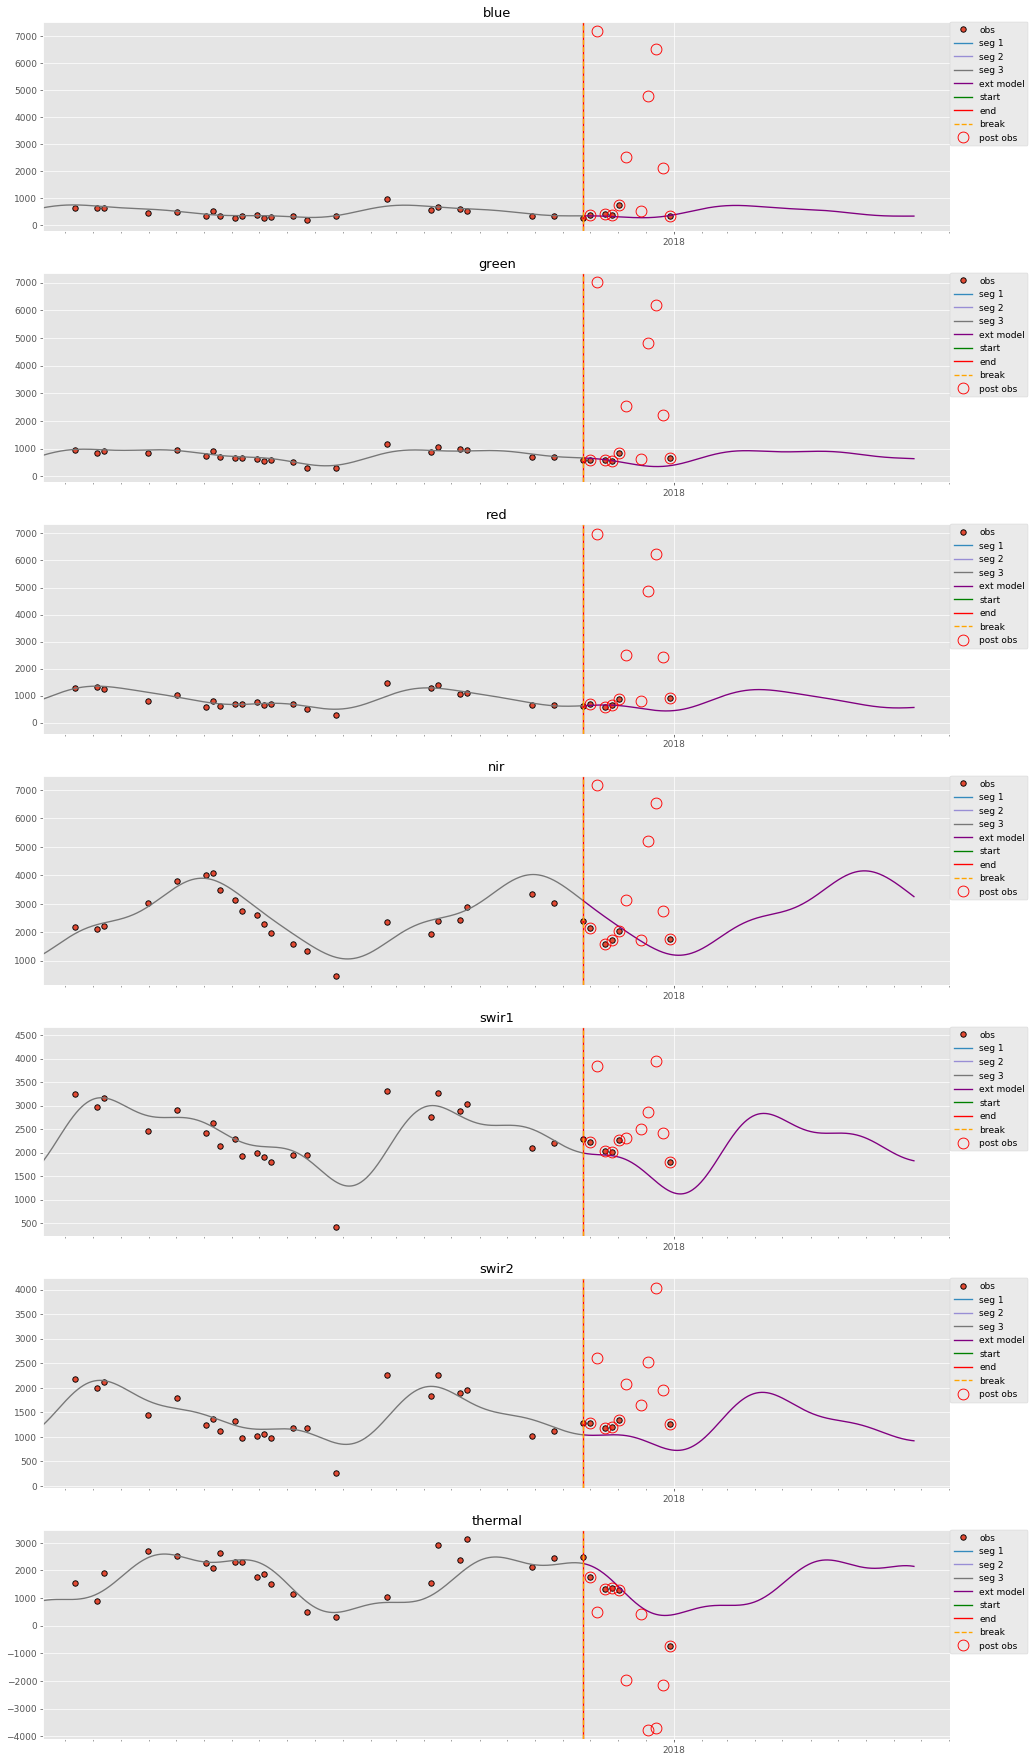

In [104]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

years = mdates.YearLocator(base=2)   # every other year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

for num, b in enumerate(bands):
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add curves to the plot
        axes[ind, 0].plot(seg_dates[n]['orddays'], curves[n][b], label=f'seg {n+1}')
        
for num, b in enumerate(bands):
    axes[num, 0].plot(extend_days, extend_curves[b], c='purple', label='ext model')

for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['sday']), color='g', label='start')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['eday']), color='r', label='end')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        # Add seg param dates to the plot
        axes[ind, 0].axvline(date_to_ord(seg_dates[n]['bday']), color='orange', linestyle='--', label='break')
        
for num, b in enumerate(bands):
    axes[num, 0].plot(post_dates, post_ard[b], marker='o', ms=12, linewidth=0, mec='red', c='none', label='post obs')
        
for n in curves.keys():
    for ind, b in enumerate(bands):
        axes[ind, 0].set_title(b)

        axes[ind, 0].xaxis.set_major_locator(years)
        axes[ind, 0].xaxis.set_major_formatter(yearsFmt)
        axes[ind, 0].xaxis.set_minor_locator(months)
        
#         axes[ind, 0].legend()
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        axes[ind, 0].legend(handles=by_label.values(), labels=by_label.keys(), ncol=1,
                            loc="upper left",
                            bbox_to_anchor=(1.00, 1.00),
                            borderaxespad=0.)

for num, b in enumerate(bands):  
    axes[num, 0].set_xlim(736000, 737000)